In [26]:
import os, itertools, math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import networkx as nx

In [27]:
csv_drought = 'data/droughts/wsh_p40_droughts.csv'
csv_ba_table = 'data/EIA930_Reference_Tables.csv'
col_region = 'Region/Country Name'
region_order = ['California', 'Northwest', 'Southwest', 'Central', 'Midwest', 'Texas', 'New England', 'New York', 'Mid-Atlantic', 'Tennessee', 'Carolinas', 'Southeast', 'Florida']
region_map = {'California': 'Western', 'Northwest': 'Western', 'Southwest': 'Western', 'Central': 'Eastern', 'Midwest': 'Eastern', 'Texas': 'Texas', 'New England': 'Eastern', 'New York': 'Eastern', 'Mid-Atlantic': 'Eastern', 'Tennessee': 'Eastern', 'Carolinas': 'Eastern', 'Southeast': 'Eastern', 'Florida': 'Eastern'}

csv_ba_center = 'data/ba-centroids-rev.csv'
csv_ba_label = 'data/ba-labels-offset.csv'
csv_data_ws = 'data/ba_solar_wind_load_monthly_1980_2019.csv'
csv_data_h = 'data/godeeep-hydro-historical-monthly.csv'
csv_data_h_meta = 'data/godeeep-hydro-plants.csv'

# check reference datasets
df_ba_center = pd.read_csv(csv_ba_center, index_col = 0)
df_ba_label = pd.read_csv(csv_ba_label, index_col = 0)
df_data_ws = pd.read_csv(csv_data_ws)
data_h_meta = pd.read_csv(csv_data_h_meta).set_index('eia_id').drop('plant', axis=1)
df_data_h = pd.read_csv(csv_data_h, parse_dates = ['datetime']).set_index('eia_id').join(data_h_meta, how='left')

# identify BAs not qualified (missing either electricity source)
df_data_ws = df_data_ws[np.isfinite(df_data_ws['solar_num_sites']) & np.isfinite(df_data_ws['wind_num_sites'])]
ba_wsh = np.intersect1d(df_data_ws['ba'].unique().astype(str), df_data_h['ba'].unique().astype(str))
ba_x = np.setdiff1d(df_ba_center.index, ba_wsh)
#print(f'BAs with all electricity sources: {ba_wsh}')
#print(f'BAs missing either electricity source: {ba_x}')
#print(f'BAs with no location: {np.setdiff1d(ba_wsh, df_ba_center.index)}')

# read a drought dataset
df_drought = pd.read_csv(csv_drought)
df_drought.index = pd.to_datetime(df_drought['datetime_utc'])
df_drought = df_drought.drop(columns = 'datetime_utc')

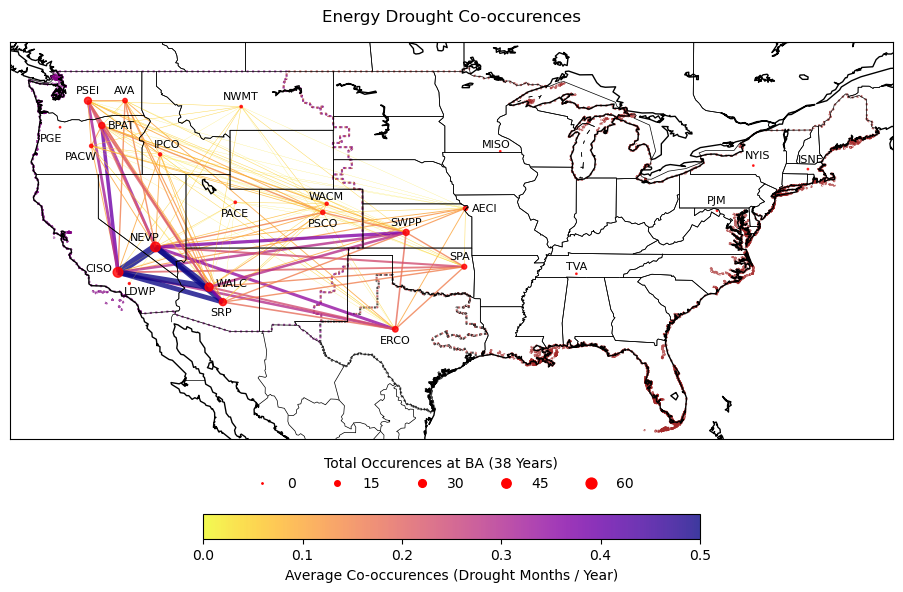

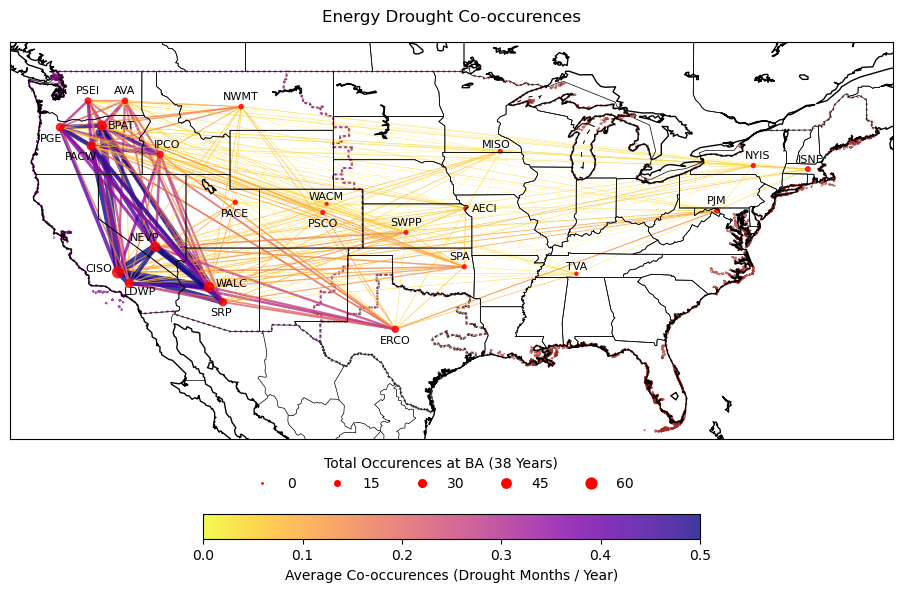

In [28]:
# identify BAs not qualified (missing either electricity source)
df_data_ws = df_data_ws[np.isfinite(df_data_ws['solar_num_sites']) & np.isfinite(df_data_ws['wind_num_sites'])]
ba_wsh = np.intersect1d(df_data_ws['ba'].unique().astype(str), df_data_h['ba'].unique().astype(str))
ba_x = np.setdiff1d(df_ba_center.index, ba_wsh)
#print(f'BAs missing either electricity source: {ba_x}')

# read a drought dataset
df_drought = pd.read_csv(csv_drought)
df_drought.index = pd.to_datetime(df_drought['datetime_utc'])
df_drought = df_drought.drop(columns = 'datetime_utc')

# merge BA lons/lats
df_ba_table = pd.read_csv(csv_ba_table, index_col = 0)
df_ba_table['Interconnection'] = df_ba_table[col_region].map(region_map)
df_drought = df_drought.merge(df_ba_table, how = 'inner', left_on = 'ba', right_index = True)
#print(df_ba_table.loc[ba_wsh, col_region].groupby(by = df_ba_table.loc[ba_wsh, col_region]).count())
df_drought = df_drought.merge(df_ba_center, how = 'inner', left_on = 'ba', right_index = True)

# expand energy drought events by duration
# comment out if double-counting one single event
for idx, df in df_drought.copy().iterrows():
    for i in range(1, df['drought_duration']):
        df_iter = df_drought.loc[df_drought['ba'] == df['ba']].loc[[idx], :]
        df_iter.index = pd.DatetimeIndex([idx + pd.offsets.MonthBegin(i)], name = 'datetime_utc')
        df_drought = pd.concat([df_drought, df_iter])
df_drought = df_drought.sort_values(['ba', 'drought_id'])

# check co-occurences
ba_bytime_all = df_drought.loc[:, 'ba'].groupby('datetime_utc').apply(list)

#seasons = {'Winter: DJF': [12, 1, 2], 'Spring: MAM': [3, 4, 5], 'Summer: JJA': [6, 7, 8], 'Fall: SON': [9, 10, 11]}
seasons = {'Winter (DJF)': [12, 1, 2], 'Fall (SON)': [9, 10, 11]}
for season, months in seasons.items():
    ba_bytime = ba_bytime_all.loc[ba_bytime_all.index.month.isin(months)]
    ba_cooccur, ba_sole = [], []
    for ba in ba_bytime:
        if len(ba) == 1: ba_sole = ba_sole + ba # sole occurence
        else: ba_cooccur = ba_cooccur + list(itertools.combinations(ba, 2)) # co-occurence

    # define nodes, edegs, and labels
    ba_nodes = df_ba_center.index.to_list()
    ba_nodepos = {key: (elem['lon'], elem['lat']) for key, elem in df_ba_center.iterrows()}
    if len(ba_bytime.tolist()) > 0: ba_nodecounts = np.array([(np.concatenate(ba_bytime.tolist()) == ba).sum() for ba in ba_nodes]) # # of months w/ energy drought
    else: ba_nodecounts = np.full(len(ba_nodes), 0)
    ba_edges, ba_edgecounts = np.unique(ba_cooccur, axis = 0, return_counts = True)
    ba_labels = {elem: elem for elem in ba_nodes}
    ba_labelpos = {key: (elem['lon'] + df_ba_label.loc[key, 'lon'], elem['lat'] + df_ba_label.loc[key, 'lat']) for key, elem in df_ba_center.iterrows()}

    if len(ba_edges) == 0: continue

    # sort to present in a descending order of cooccurences: not working as networkx not preserving edge orders
    #ba_sort = np.argsort(ba_edgecounts)
    #ba_edges = ba_edges[ba_sort]
    #ba_edgecounts = ba_edgecounts[ba_sort]

    # remove BAs not qualified (missing either electricity source)
    idx_sel = [ba_nodes.index(ba) for ba in np.setdiff1d(ba_nodes, ba_x)]
    ba_nodes = np.array(ba_nodes)[idx_sel].tolist()
    ba_nodecounts = np.array(ba_nodecounts)[idx_sel]
    ba_labelpos = {ba: ba_labelpos[ba] for ba in ba_nodes}
    ba_labels = {ba: ba_labels[ba] for ba in ba_nodes}

    # define networks
    G = nx.Graph()
    G.add_nodes_from(ba_nodes)
    G.add_edges_from(ba_edges)
    #G.add_weighted_edges_from(((*edge, w) for edge, w in zip(ba_edges, ba_sort)))

    # plot
    fig, ax = plt.subplots(figsize = (10, 6))
    #fig.suptitle(f'Energy Drought Co-occurences ({season})')#: {csv_drought}')
    fig.suptitle(f'Energy Drought Co-occurences')#: {csv_drought}')
    m = Basemap(projection = 'cyl', llcrnrlon = -126, llcrnrlat = 24, urcrnrlon = -66, urcrnrlat = 51, resolution = 'l')
    m.drawcoastlines(zorder = 9)
    m.drawcountries(zorder = 9)
    m.drawstates(zorder = 9)

    m.readshapefile(os.path.join('data', 'NERC_Interconnections_EWT_proj', 'NERC_Interconnections_E_proj'), 'EI', drawbounds = False)
    m.readshapefile(os.path.join('data', 'NERC_Interconnections_EWT_proj', 'NERC_Interconnections_W_proj'), 'WI', drawbounds = False)
    m.readshapefile(os.path.join('data', 'NERC_Interconnections_EWT_proj', 'NERC_Interconnections_T_proj'), 'ERCOT', drawbounds = False)
    patches_EI = [matplotlib.patches.Polygon(np.array(shape), closed = True) for shape in m.EI]
    patches_WI = [matplotlib.patches.Polygon(np.array(shape), closed = False) for shape in m.WI]
    patches_ERCOT = [matplotlib.patches.Polygon(np.array(shape), closed = False) for shape in m.ERCOT]
    ax.add_collection(matplotlib.collections.PatchCollection(patches_EI, facecolor = 'None', edgecolor = 'brown', linestyle = ':', linewidths = 1.5, alpha = 0.7))
    ax.add_collection(matplotlib.collections.PatchCollection(patches_WI, facecolor = 'None', edgecolor = 'purple', linestyle = ':', linewidths = 1.5, alpha = 0.7))
    ax.add_collection(matplotlib.collections.PatchCollection(patches_ERCOT, facecolor = 'none', edgecolor = 'black', linestyle = ':', linewidths = 1.5, alpha = 0.7))

    nodes = nx.draw_networkx_nodes(G, ba_nodepos, node_size = 1 + ba_nodecounts, node_color = 'red', alpha = 0.8)
    edges = nx.draw_networkx_edges(G, ba_nodepos, width = ba_edgecounts / 6, edge_color = ba_edgecounts / 38, edge_cmap = plt.cm.plasma_r, alpha = 0.8, edge_vmin = 0, edge_vmax = 0.5)
    labels = nx.draw_networkx_labels(G, ba_labelpos, labels = ba_labels, font_size = 8) #, bbox = {'ec': 'k', 'fc': 'white', 'alpha': 0.7})

    if len(ba_edges) > 0: plt.colorbar(edges, fraction = 0.05, location = 'bottom', orientation = 'horizontal', label = 'Average Co-occurences (Drought Months / Year)')
    for n in np.arange(0, 61, 15): plt.plot([], [], 'ro', markersize = math.sqrt(1 + n), label = f'{n}')
    plt.legend(loc = 'lower right', ncols = 5, bbox_to_anchor = (0.72, -0.16), title = 'Total Occurences at BA (38 Years)', frameon = False)
    plt.tight_layout()
    plt.savefig(f'figures/FIGURE02a_{season}.png', bbox_inches = 'tight', dpi = 300)
    plt.show()